In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from scipy.signal import convolve2d
from scipy.signal import convolve
import copy

In [2]:
"""
Changeable parameters
"""

n_strains = 2
n_nutrients = 2

t_final = 0.2 #hours
dt = 0.1 #hours


#The dependencies of strain the strains on each nutrient. Within each strain and nutrient, COLUMN 1 is UPTAKE, 
#COLUMN 2 is RELEASE. 1 means they do that function, 0 means they do not
dependencies = np.zeros((n_strains,n_nutrients,2))

#This initialization is for classic CoSMO type crossfeeding.
dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,0,1] = 1 #strain 2, release nutrient 1



In [3]:
"""
general variables for diffusion
"""

side_len = 100 #microns
box_height = 1000 #microns
cell_size = 5 #microns
cell_to_diff_ratio = 5
density = 100 #mm^-2

D = 20

In [4]:
def populate_X_S_internal(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies):
    
    n_cells = int(density*cell_size**2*side_len**2/1e6)
    
    #seed in a box of width side_len/4
    width = int(cell_sides/4)
    offset = int(cell_sides/2 - cell_sides/8)
    
    for nn in range(n_cells):
        x = int(width*np.random.rand()) + offset
        y = int(width*np.random.rand()) + offset
        z = 0 #int(width*np.random.rand())
        
        #pick which strain this position will be
        strain_identifier = int(np.floor((np.random.rand()-0.5)*n_strains + 1) + 1)
        
        #loop through nutrients to populate the internal nutrient arrays. We will only consider internal nutrients
        #required for growth. (So only nutrients that a cell type uptakes)
        for uu in range(n_nutrients):
            
            #Only populate internal state if uptake dependency is non-zero
            ammnt = np.random.rand()*nutrients['%s'%uu]['alpha']*dependencies[strain_identifier-1,uu,0] 
            
            #populate the grid position with the initialized concentration
            nutrients['%s'%uu]['S_internal'][x,y,z] = ammnt
            
        X[x,y,z] = strain_identifier
        
    return X

In [5]:
def sum_collapse_array(M,n):
    
    #from ChatGPT
    """
    Reduces a 3D tensor M by computing the sum of points in non-overlapping n x n x n blocks.
    
    Parameters:
        M (np.ndarray): The input 3D array.
        n (int): The size of the blocks used for density calculation.
        
    Returns:
        np.ndarray: The resulting 3D tensor P containing densities of each n x n x n block.
    """
    # Ensure M is a numpy array
    M = np.asarray(M)
    d1, d2, d3 = M.shape
    
    # Check if M dimensions are divisible by n
    if d1 % n != 0 or d2 % n != 0 or d3 % n != 0:
        raise ValueError("All dimensions of the tensor must be divisible by the block size n.")
    
    # Reshape M into a 6D array where each block is n x n x n
    reshaped = M.reshape(d1 // n, n, d2 // n, n, d3 // n, n)
    
    # Calculate density for each block
    densities = np.sum(reshaped != 0, axis=(1, 3, 5))# / (n * n * n)
    
    return densities

In [6]:
def draw(M):
    
    X_1 = X.copy()
    X_2 = X.copy()
    X_1[X!=1] = 0
    X_2[X!=2] = 0
        
    dens1 = sum_collapse_array(X_1,cell_to_diff_ratio)
    dens2 = sum_collapse_array(X_2,cell_to_diff_ratio)
    
    """draw the concentrations"""
    fig, ax = plt.subplots(1,3,figsize=(50,25))
    ax[0].imshow(M[:,:,0], cmap='hot')
    ax[1].imshow(dens1[:,:,0], cmap='Greys')
    ax[2].imshow(dens2[:,:,0],cmap = 'Greys')
    ax[0].set_title('original XY',fontsize=50)
    ax[1].set_title('density type 1 XY',fontsize=50)
    ax[2].set_title('density type 2 XY',fontsize=50)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    
    return X_1, X_2

In [7]:
def periodic_image(coord,dimension):
    return int(coord%dimension)

In [8]:
def bud(x,y,z,X_og,typ):
    
    """
    The general strategy will be to generate a list of adjacent points with respect to periodic boundary 
    conditions. Then, make a smaller list of these points that are empty. If there are no empty points in the 
    plane, we will search the plane above. Once a list of potential points has been generated, the cell will 
    randomly bud into one. 
    """
    
    X = X_og.copy()
    
    #the coordinates of the cell to be propagated
    coords = np.array([x,y,z])
    
    shp = np.shape(X)
    
    
    #make a 3x3 stencil to search with
    xes = np.zeros(9)
    yes = np.zeros(9)

    xes[:3] = periodic_image(coords[0] - 1,shp[0])
    xes[3:6] = periodic_image(coords[0],shp[0])
    xes[6:] = periodic_image(coords[0] + 1,shp[0])

    yes[0::3] = periodic_image(coords[1] - 1,shp[1])
    yes[1::3] = periodic_image(coords[1],shp[1])
    yes[2::3] = periodic_image(coords[1] + 1,shp[1])
    
    
    poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    
    n_possibilities = np.size(poss_xvals)
    floor = 0
    
    success = True

    
    if n_possibilities == 0:
        #print('trying one floor up')
        
        new_poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]
        new_poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]

        n_new_possibilities = np.size(new_poss_xvals)
        
        if n_new_possibilities == 0:
            print('no available space, cannot bud')
            success = False
        else:
            poss_xvals = new_poss_xvals
            poss_yvals = new_poss_yvals
            n_possibilities = n_new_possibilities
            floor = 1
            
    if success:
        index_to_bud = int(np.floor(np.random.rand()*n_possibilities))

        X[int(poss_xvals[index_to_bud]),int(poss_yvals[index_to_bud]),int(coords[2]+floor)] = typ
        
    return X

In [9]:
"""
It is time to test our functions! Firstly, we want to ensure that if we initialize a configuration with one
buddable cell, that that cell appropriately buds and that the corresponding internal nutrient arrays are 
appropriately updated. We will repeat the same process for the other cell type (just to be sure). Finally, one of 
the major goals of this code is to be sensitive to any number of dependencies, so we will test that a non-trivial
cell type will behave similarly to the simple cases.
"""

'\nIt is time to test our functions! Firstly, we want to ensure that if we initialize a configuration with one\nbuddable cell, that that cell appropriately buds and that the corresponding internal nutrient arrays are \nappropriately updated. We will repeat the same process for the other cell type (just to be sure). Finally, one of \nthe major goals of this code is to be sensitive to any number of dependencies, so we will test that a non-trivial\ncell type will behave similarly to the simple cases.\n'

In [10]:
"""
calculated quantities
"""
#the box to keep cells in
cell_sides = int(side_len/cell_size)
cell_height = int(box_height/cell_size)
X = np.zeros((cell_sides,cell_sides,cell_height))

print('integer width = ',cell_sides)

#the boxes for each nutrient
diff_sides = int(cell_sides/cell_to_diff_ratio)
diff_height = int(cell_height/cell_to_diff_ratio)

#The blank matrix into which nutrients will go
S = np.zeros((diff_sides,diff_sides,diff_height))

integer width =  20


In [11]:
"""
nutrient variables
"""
#We are going to do something a little wild here. Because all of our CoSMO strains have the same genetic background
#outside of the specific mutations, we are going to assume that the effect of growth of the various nutrients on
#different strains is the same. That is, we can define how a nutrient affects cell growth and apply those same 
#rates to every other cell that depends on that nutrient. In this manner, we can write out all of the rates
#for each nutrient once and then simply apply those constraints to a cell's growth by defining its dependencies. 
#This will further allow us to flexibly modulate the various interdependencies of different cell types.

#Lys
alphaL = 5.4 #nutrient required for reproduction (fmole)
rL = 0.51 #Maximum growth rate (hr^-1)
vmL = alphaL*rL #maximum uptake rate (fmole/hr)
KL = 2.1e6 #Monod constant (fmole/ml)
gammaL = 0.4 #release rate (fmole/(cell*hr))
dL = 0.0021 #death rate (hr^-1)

#Ade
alphaA = 3.1
rA = 0.44
vmA = alphaA*rA
KA = 1.3e6
gammaA = 0.26
dA = 0.015 #death rate (hr^-1). Should this be an order of magnitude higher?

nutrients = {
    '0':{
        'alpha': alphaL,
        'S' : S,
        'r' : rL,
        'vm' : vmL,
        'Km' : KL,
        'gamma' : gammaL,
        'S_internal' : X.copy(),
        'd' : dL
    },
    '1':{
        'alpha': alphaA,
        'S' : S,
        'r' : rA,
        'vm' : vmA,
        'Km' : KA,
        'gamma' : gammaA,
        'S_internal' : X.copy(),
        'd' : dA
    }
}

In [12]:
typ = 2
x,y,z = 10,9,0

X[x,y,z] = typ
X[9,9,0] = 1


#This is the simplest contrived setup I can think of. We will simply set the internal nutrient concentrations of 
#an isolated cell as the exact concentrations required to bud. This should also allow us to test more exotic 
#uptake schemes easily.

which_dependency = {}
for nn in range(n_nutrients):
    if dependencies[int(typ-1),nn,0]==1: 
        nutrients['%s'%nn]['S_internal'][x,y,z] = nutrients['%s'%nn]['alpha']
        
X_original = X.copy()
nutrients_og = copy.deepcopy(nutrients)


In [13]:
nsteps = int(t_final/dt)
time = np.arange(nsteps)/dt

for tt in range(nsteps):
    
    #start by getting all of the identities and coordinates for each cell
    x,y,z = np.where(X!=0)
    number = np.size(x)
    #print('n live cells = ', number)
    
    indicies = np.arange(number)

    #shuffle the order so that we chose cells at random
    #n.b. np.random.shuffle() preforms in place, so no need to assign the output to an array.
    np.random.shuffle(indicies)

    #loop over each cell and enumerate it's parameters
    for ii in indicies:
        typ = X[x[ii],y[ii],z[ii]]
        #print('cell type = ', typ)

        #only consider live cells
        print('life condition = ',typ%1==0)
        if typ%1!=0:
            continue

        #try to kill it
        rnd = np.random.rand()
        prob_death = nutrients['%s'%int(typ-1)]['d']*dt*5
        if rnd<prob_death:
            print('Death')
            X[x,y,z] += -0.5
            continue



        """
        %We will now ask wether or not a given cell buds. This is not so straightforward. We want to be able to 
        accomodate a strain that requires any number of nutrients for growth. In the absence of any dependencies, we 
        will dictate that the probability of division is simply growth rate, r, times the change in time, dt. In the 
        case of nutrient dependency, we will say that a cell buds if ALL of its nutrient dependencies are filled.
        """
        #assess the requirements for budding
        budded = 0
        n_requirements = 0
        which_dependency = {}
        for nn in range(n_nutrients):

            if dependencies[int(typ-1),nn,0]==1: 
                which_dependency['%s'%int(n_requirements)] = nn

            n_requirements += dependencies[int(typ-1),nn,0] #hardcoded 0 here; we only consider uptake dependencies



        #decide if budding occurred
        if n_requirements == 0:

            rnd = np.random.rand()
            prob_division = nutrients['0']['r']*dt

            if rnd<prob_division:
                budded = 1


        else: 

            condition_success = np.zeros(int(n_requirements))
            
            for rr in range(int(n_requirements)):
                amount_internal_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['S_internal'][x[ii],y[ii],z[ii]]
                amount_required_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['alpha']

                if amount_internal_nutrient >= amount_required_nutrient:
                    condition_success[rr] = 1

            if condition_success.all():
                budded = 1


        """
        Now that we have decided if something has budded let us determine where the bud goes
        """
        if budded:
            #print('budded!')
            X = bud(x[ii],y[ii],z[ii],X,typ)

            for rr in range(int(n_requirements)):
                amount_internal_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['S_internal'][x[ii],y[ii],z[ii]] = 0


life condition =  True
life condition =  True
life condition =  True
life condition =  True
life condition =  True


In [14]:
def draw_config_conc(X,nutrients,n_nutrients,title):
    
    
    fig, ax = plt.subplots(1,n_nutrients+1,figsize=(50,25))
    fig.suptitle(title,fontsize=75)
    ax[0].imshow(X[:,:,0], cmap='hot')
    ax[0].set_title('strain identities XY',fontsize=50)
    ax[0].axis('off')
    
    for nn in range(n_nutrients):
        
        indicator = nn+1
        
        #print(np.unique(nutrients['%s'%nn]['S_internal'][:,:,0]))
        
        ax[indicator].imshow(nutrients['%s'%nn]['S_internal'][:,:,0], cmap='Greys')
        ax[indicator].set_title('nutrient %s'%indicator,fontsize=50)
        ax[indicator].axis('off')
    

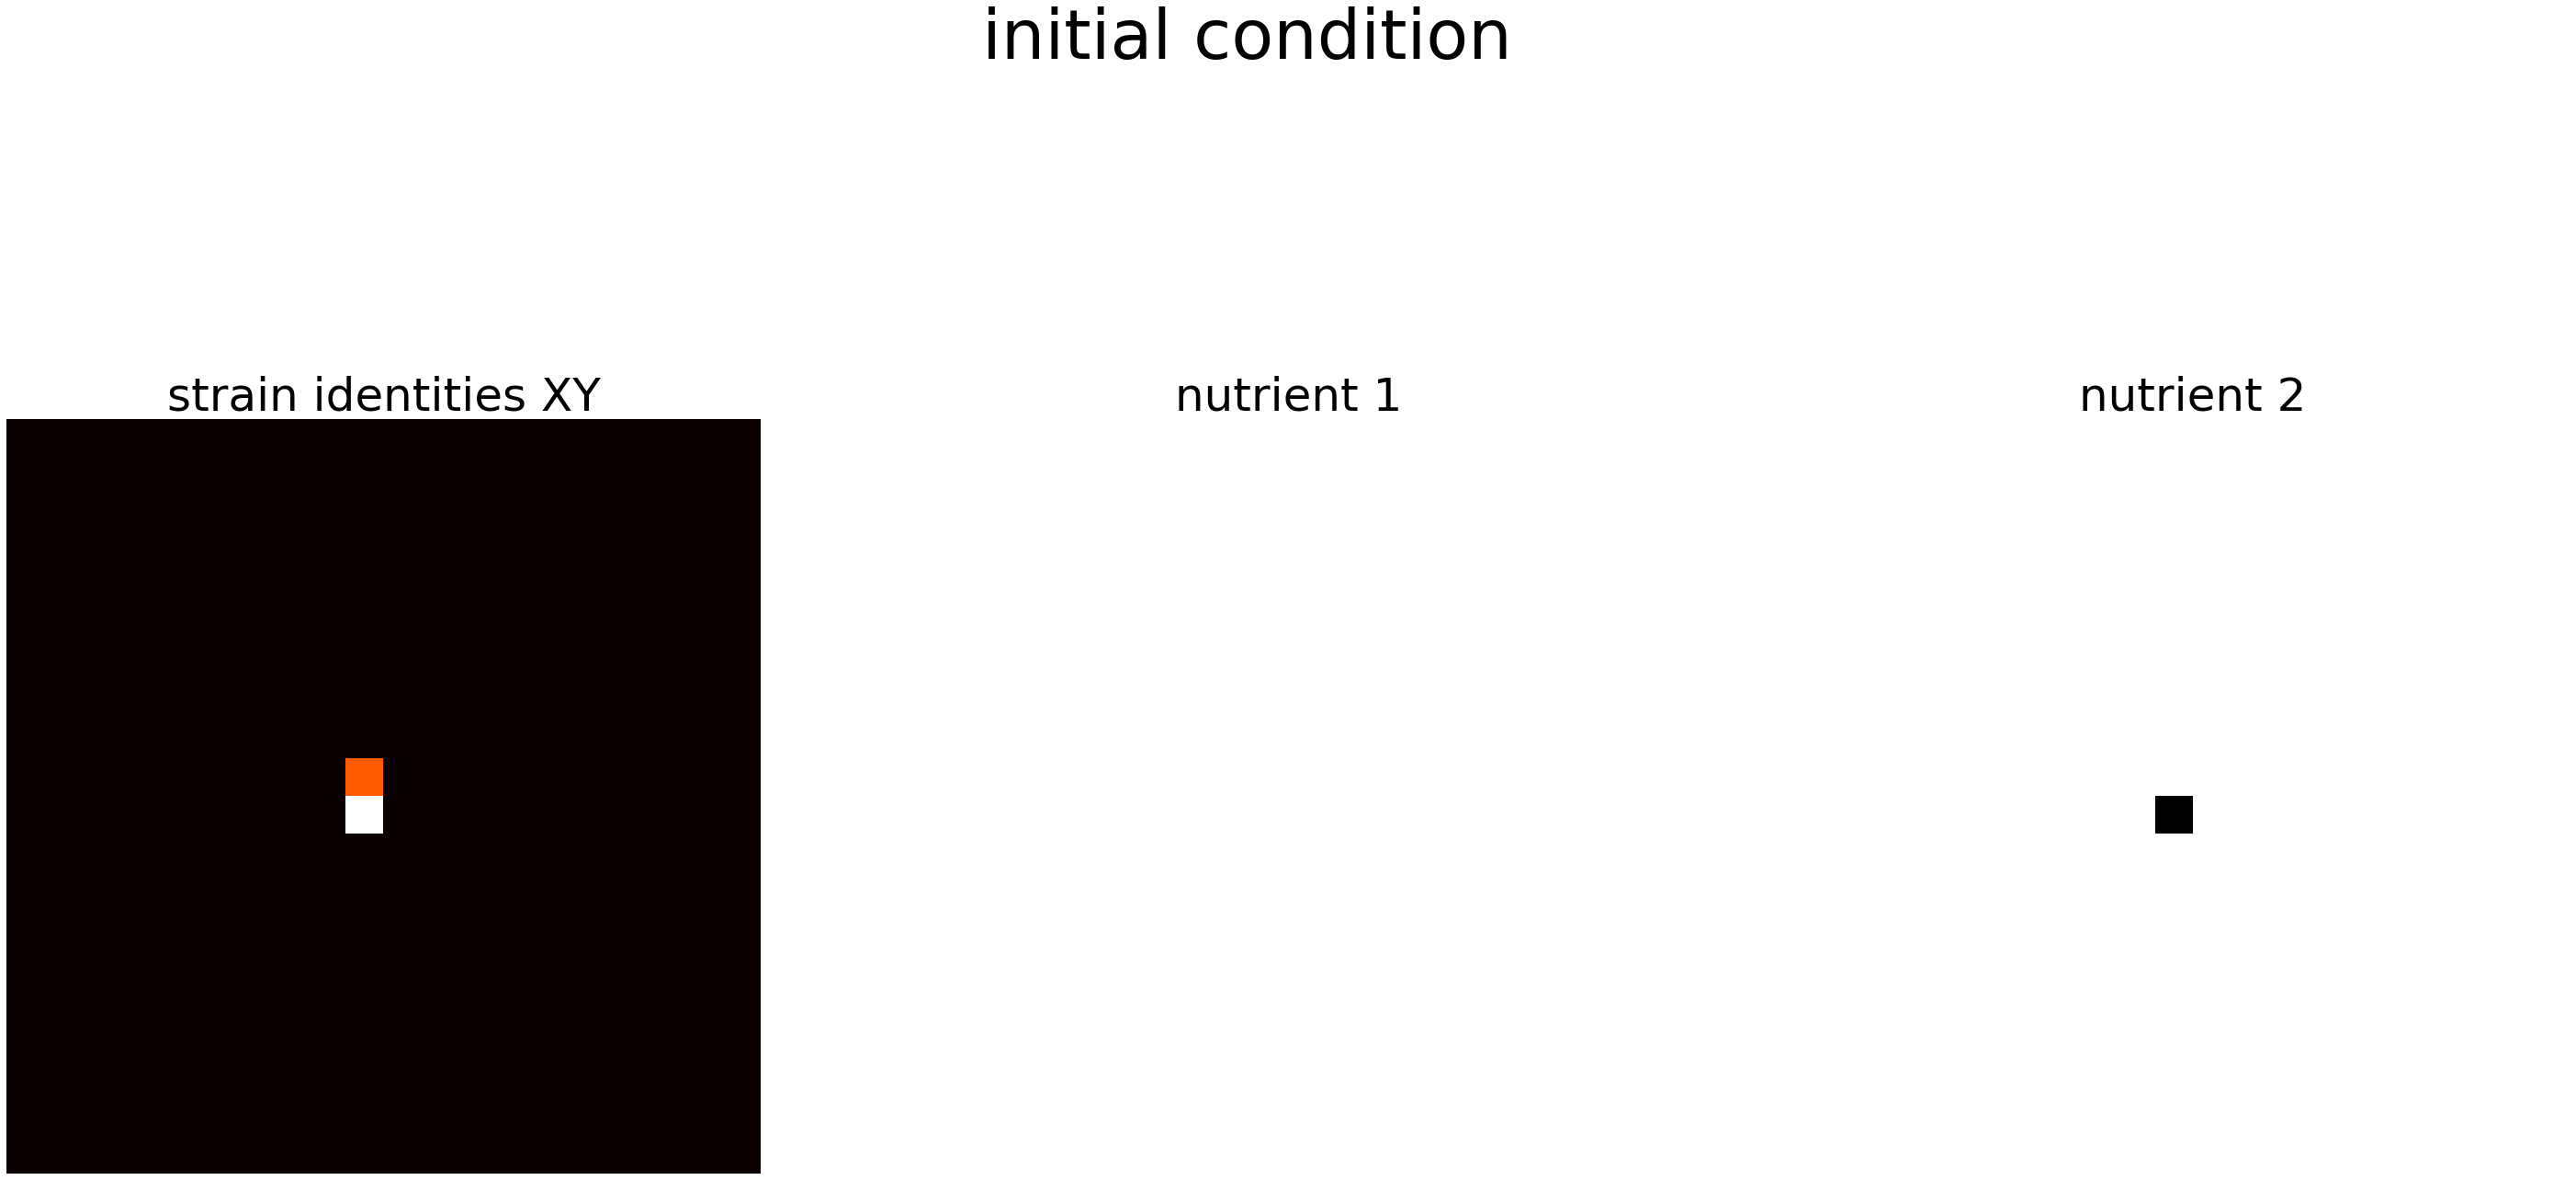

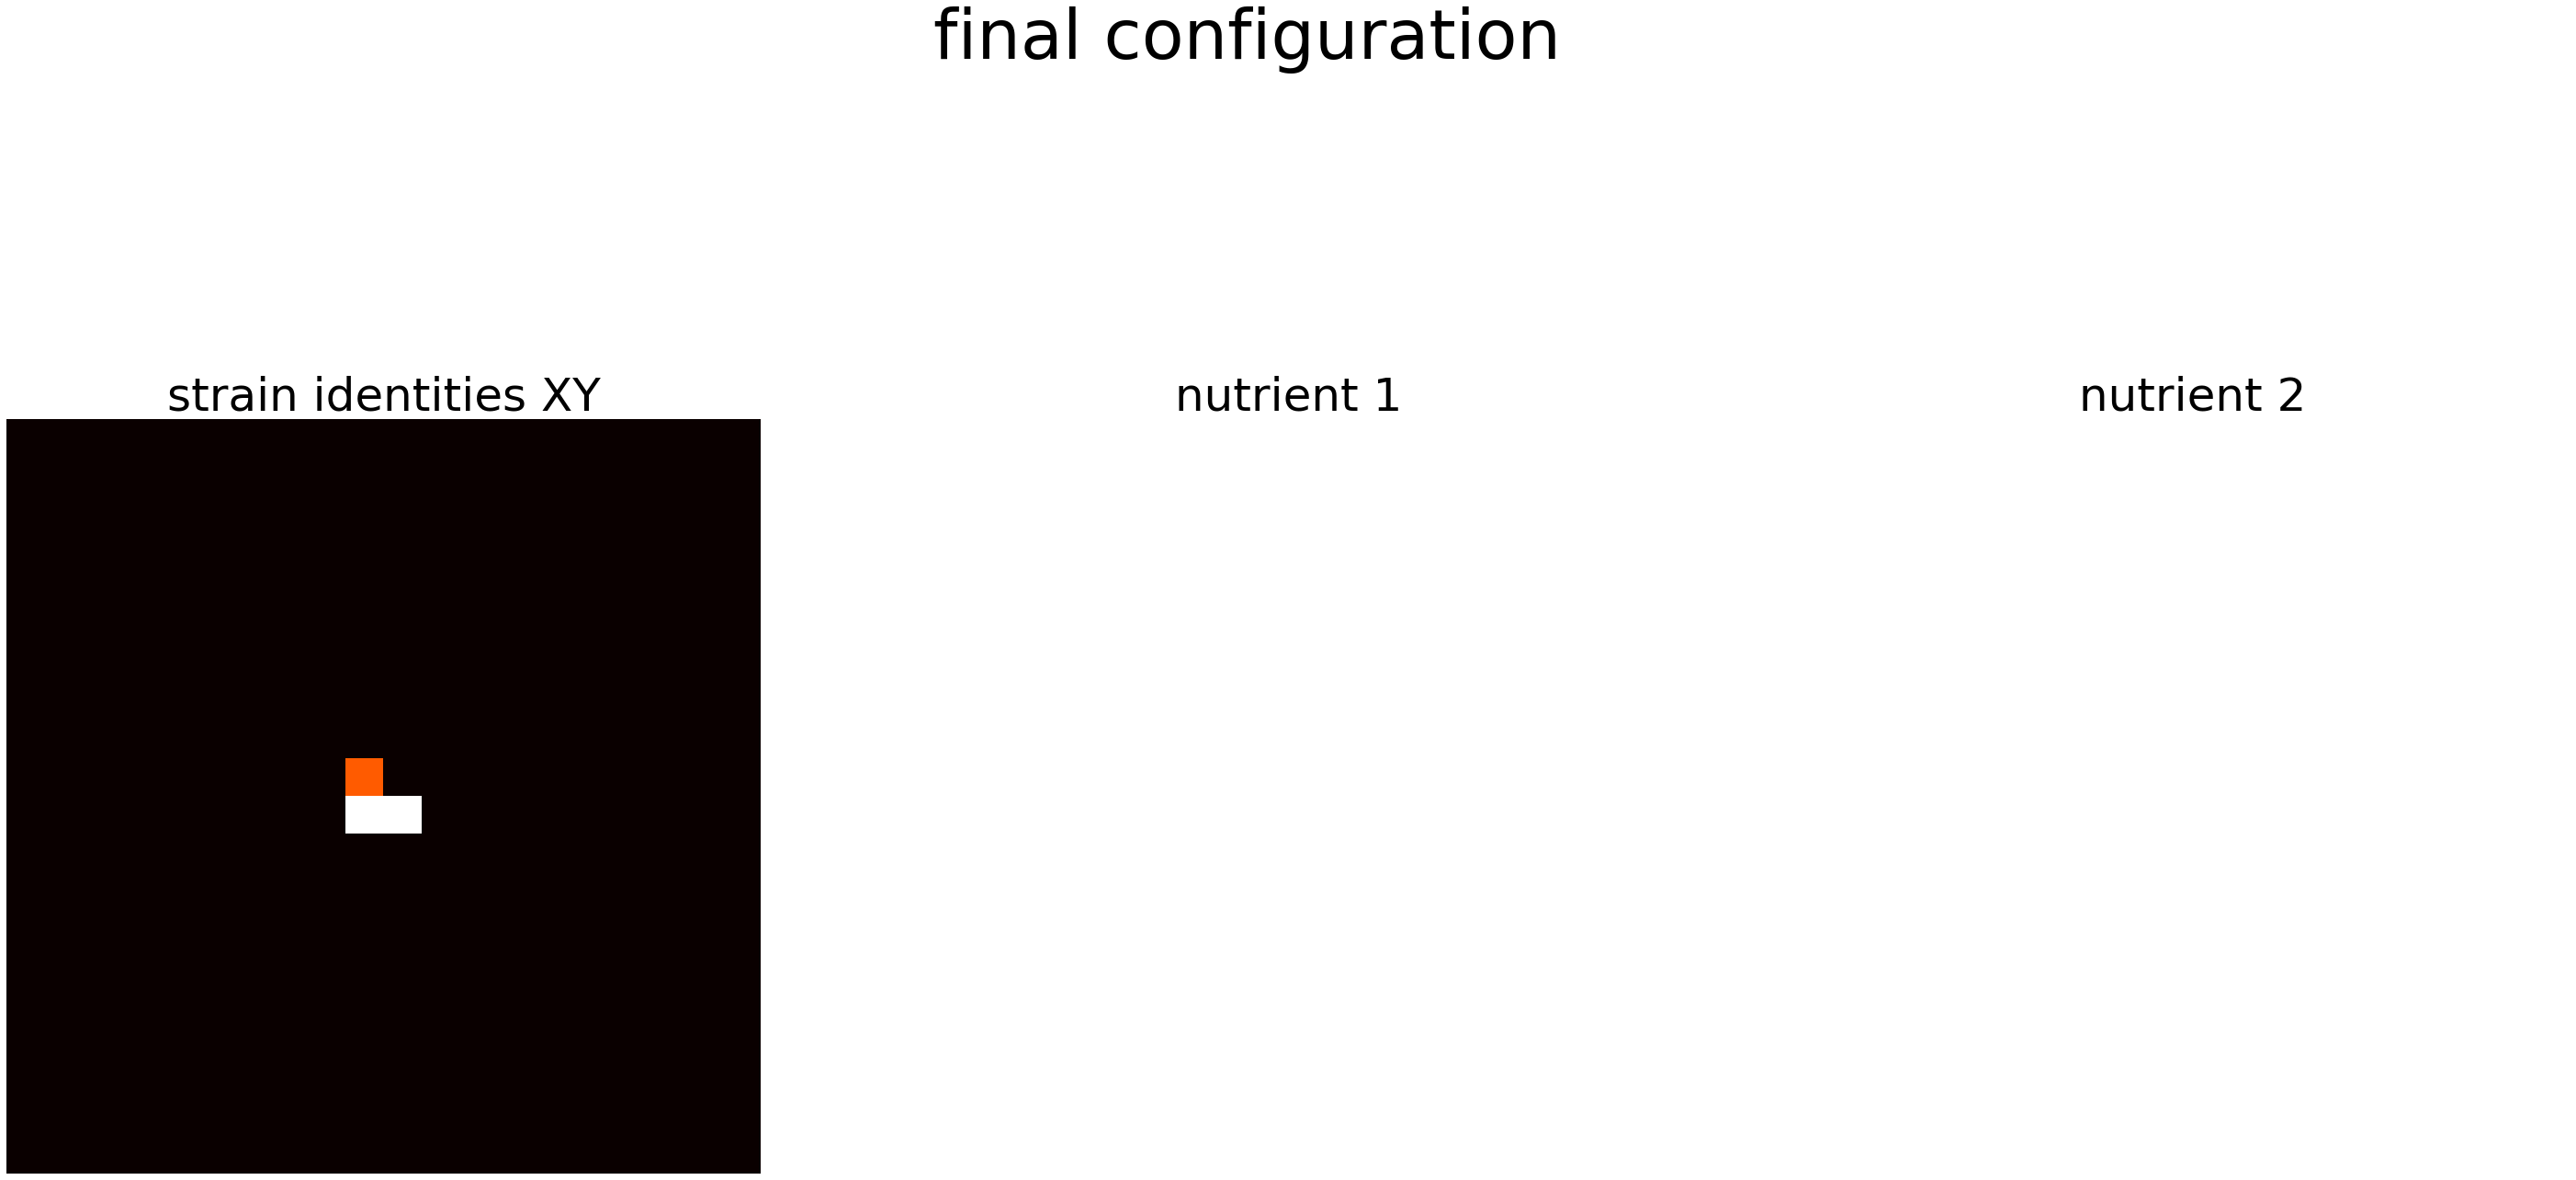

In [15]:
draw_config_conc(X_original,nutrients_og,n_nutrients,'initial condition')
draw_config_conc(X,nutrients,n_nutrients,'final configuration')

In [16]:
def iterate_life_and_death(X,n_nutrients,nutrients,dependencies):
    #start by getting all of the identities and coordinates for each cell
    x,y,z = np.where(X!=0)
    number = np.size(x)
    #print('n live cells = ', number)
    
    indicies = np.arange(number)

    #shuffle the order so that we chose cells at random
    #n.b. np.random.shuffle() preforms in place, so no need to assign the output to an array.
    np.random.shuffle(indicies)

    #loop over each cell and enumerate it's parameters
    for ii in indicies:
        typ = X[x[ii],y[ii],z[ii]]
        #print('cell type = ', typ)

        #only consider live cells
        #print('life condition = ',typ%1==0)
        if typ%1!=0:
            continue

        #try to kill it
        rnd = np.random.rand()
        prob_death = nutrients['%s'%int(typ-1)]['d']*dt
        if rnd<prob_death:
            print('Death')
            X[x,y,z] += -0.5
            draw_config_conc(X,nutrients,n_nutrients,'configuration t = %s'%(dt + dt*tt))
            continue



        """
        %We will now ask wether or not a given cell buds. This is not so straightforward. We want to be able to 
        accomodate a strain that requires any number of nutrients for growth. In the absence of any dependencies, we 
        will dictate that the probability of division is simply growth rate, r, times the change in time, dt. In the 
        case of nutrient dependency, we will say that a cell buds if ALL of its nutrient dependencies are filled.
        """
        #assess the requirements for budding
        budded = 0
        n_requirements = 0
        which_dependency = {}
        for nn in range(n_nutrients):

            if dependencies[int(typ-1),nn,0]==1: 
                which_dependency['%s'%int(n_requirements)] = nn

            n_requirements += dependencies[int(typ-1),nn,0] #hardcoded 0 here; we only consider uptake dependencies



        #decide if budding occurred
        if n_requirements == 0:

            rnd = np.random.rand()
            prob_division = nutrients['0']['r']*dt

            if rnd<prob_division:
                budded = 1


        else: 

            condition_success = np.zeros(int(n_requirements))
            
            for rr in range(int(n_requirements)):
                amount_internal_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['S_internal'][x[ii],y[ii],z[ii]]
                amount_required_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['alpha']

                if amount_internal_nutrient >= amount_required_nutrient:
                    condition_success[rr] = 1

            if condition_success.all():
                budded = 1


        """
        Now that we have decided if something has budded let us determine where the bud goes
        """
        if budded:
            #print('budded!')
            X = bud(x[ii],y[ii],z[ii],X,typ)

            for rr in range(int(n_requirements)):
                amount_internal_nutrient = nutrients['%s'%which_dependency['%s'%rr]]['S_internal'][x[ii],y[ii],z[ii]] = 0
    return X,nutrients

In [17]:
#initialize
"""
calculated quantities
"""
#the box to keep cells in
cell_sides = int(side_len/cell_size)
cell_height = int(box_height/cell_size)
X = np.zeros((cell_sides,cell_sides,cell_height))

print('integer width = ',cell_sides)

#the boxes for each nutrient
diff_sides = int(cell_sides/cell_to_diff_ratio)
diff_height = int(cell_height/cell_to_diff_ratio)

#The blank matrix into which nutrients will go
S = np.zeros((diff_sides,diff_sides,diff_height))

integer width =  20


In [18]:
"""
nutrient variables
"""
#We are going to do something a little wild here. Because all of our CoSMO strains have the same genetic background
#outside of the specific mutations, we are going to assume that the effect of growth of the various nutrients on
#different strains is the same. That is, we can define how a nutrient affects cell growth and apply those same 
#rates to every other cell that depends on that nutrient. In this manner, we can write out all of the rates
#for each nutrient once and then simply apply those constraints to a cell's growth by defining its dependencies. 
#This will further allow us to flexibly modulate the various interdependencies of different cell types.

#Lys
alphaL = 5.4 #nutrient required for reproduction (fmole)
rL = 0.51 #Maximum growth rate (hr^-1)
vmL = alphaL*rL #maximum uptake rate (fmole/hr)
KL = 2.1e6 #Monod constant (fmole/ml)
gammaL = 0.4 #release rate (fmole/(cell*hr))
dL = 0.0021 #death rate (hr^-1)

#Ade
alphaA = 3.1
rA = 0.44
vmA = alphaA*rA
KA = 1.3e6
gammaA = 0.26
dA = 0.015 #death rate (hr^-1). Should this be an order of magnitude higher?

nutrients = {
    '0':{
        'alpha': alphaL,
        'S' : S,
        'r' : rL,
        'vm' : vmL,
        'Km' : KL,
        'gamma' : gammaL,
        'S_internal' : X.copy(),
        'd' : dL
    },
    '1':{
        'alpha': alphaA,
        'S' : S,
        'r' : rA,
        'vm' : vmA,
        'Km' : KA,
        'gamma' : gammaA,
        'S_internal' : X.copy(),
        'd' : dA
    }
}

In [19]:
typ = 2
x,y,z = 10,9,0

X[x,y,z] = typ
X[9,9,0] = 1


#This is the simplest contrived setup I can think of. We will simply set the internal nutrient concentrations of 
#an isolated cell as the exact concentrations required to bud. This should also allow us to test more exotic 
#uptake schemes easily.

which_dependency = {}
for nn in range(n_nutrients):
    if dependencies[int(typ-1),nn,0]==1: 
        nutrients['%s'%nn]['S_internal'][x,y,z] = nutrients['%s'%nn]['alpha']
        
X_original = X.copy()
nutrients_og = copy.deepcopy(nutrients)


Done! :D


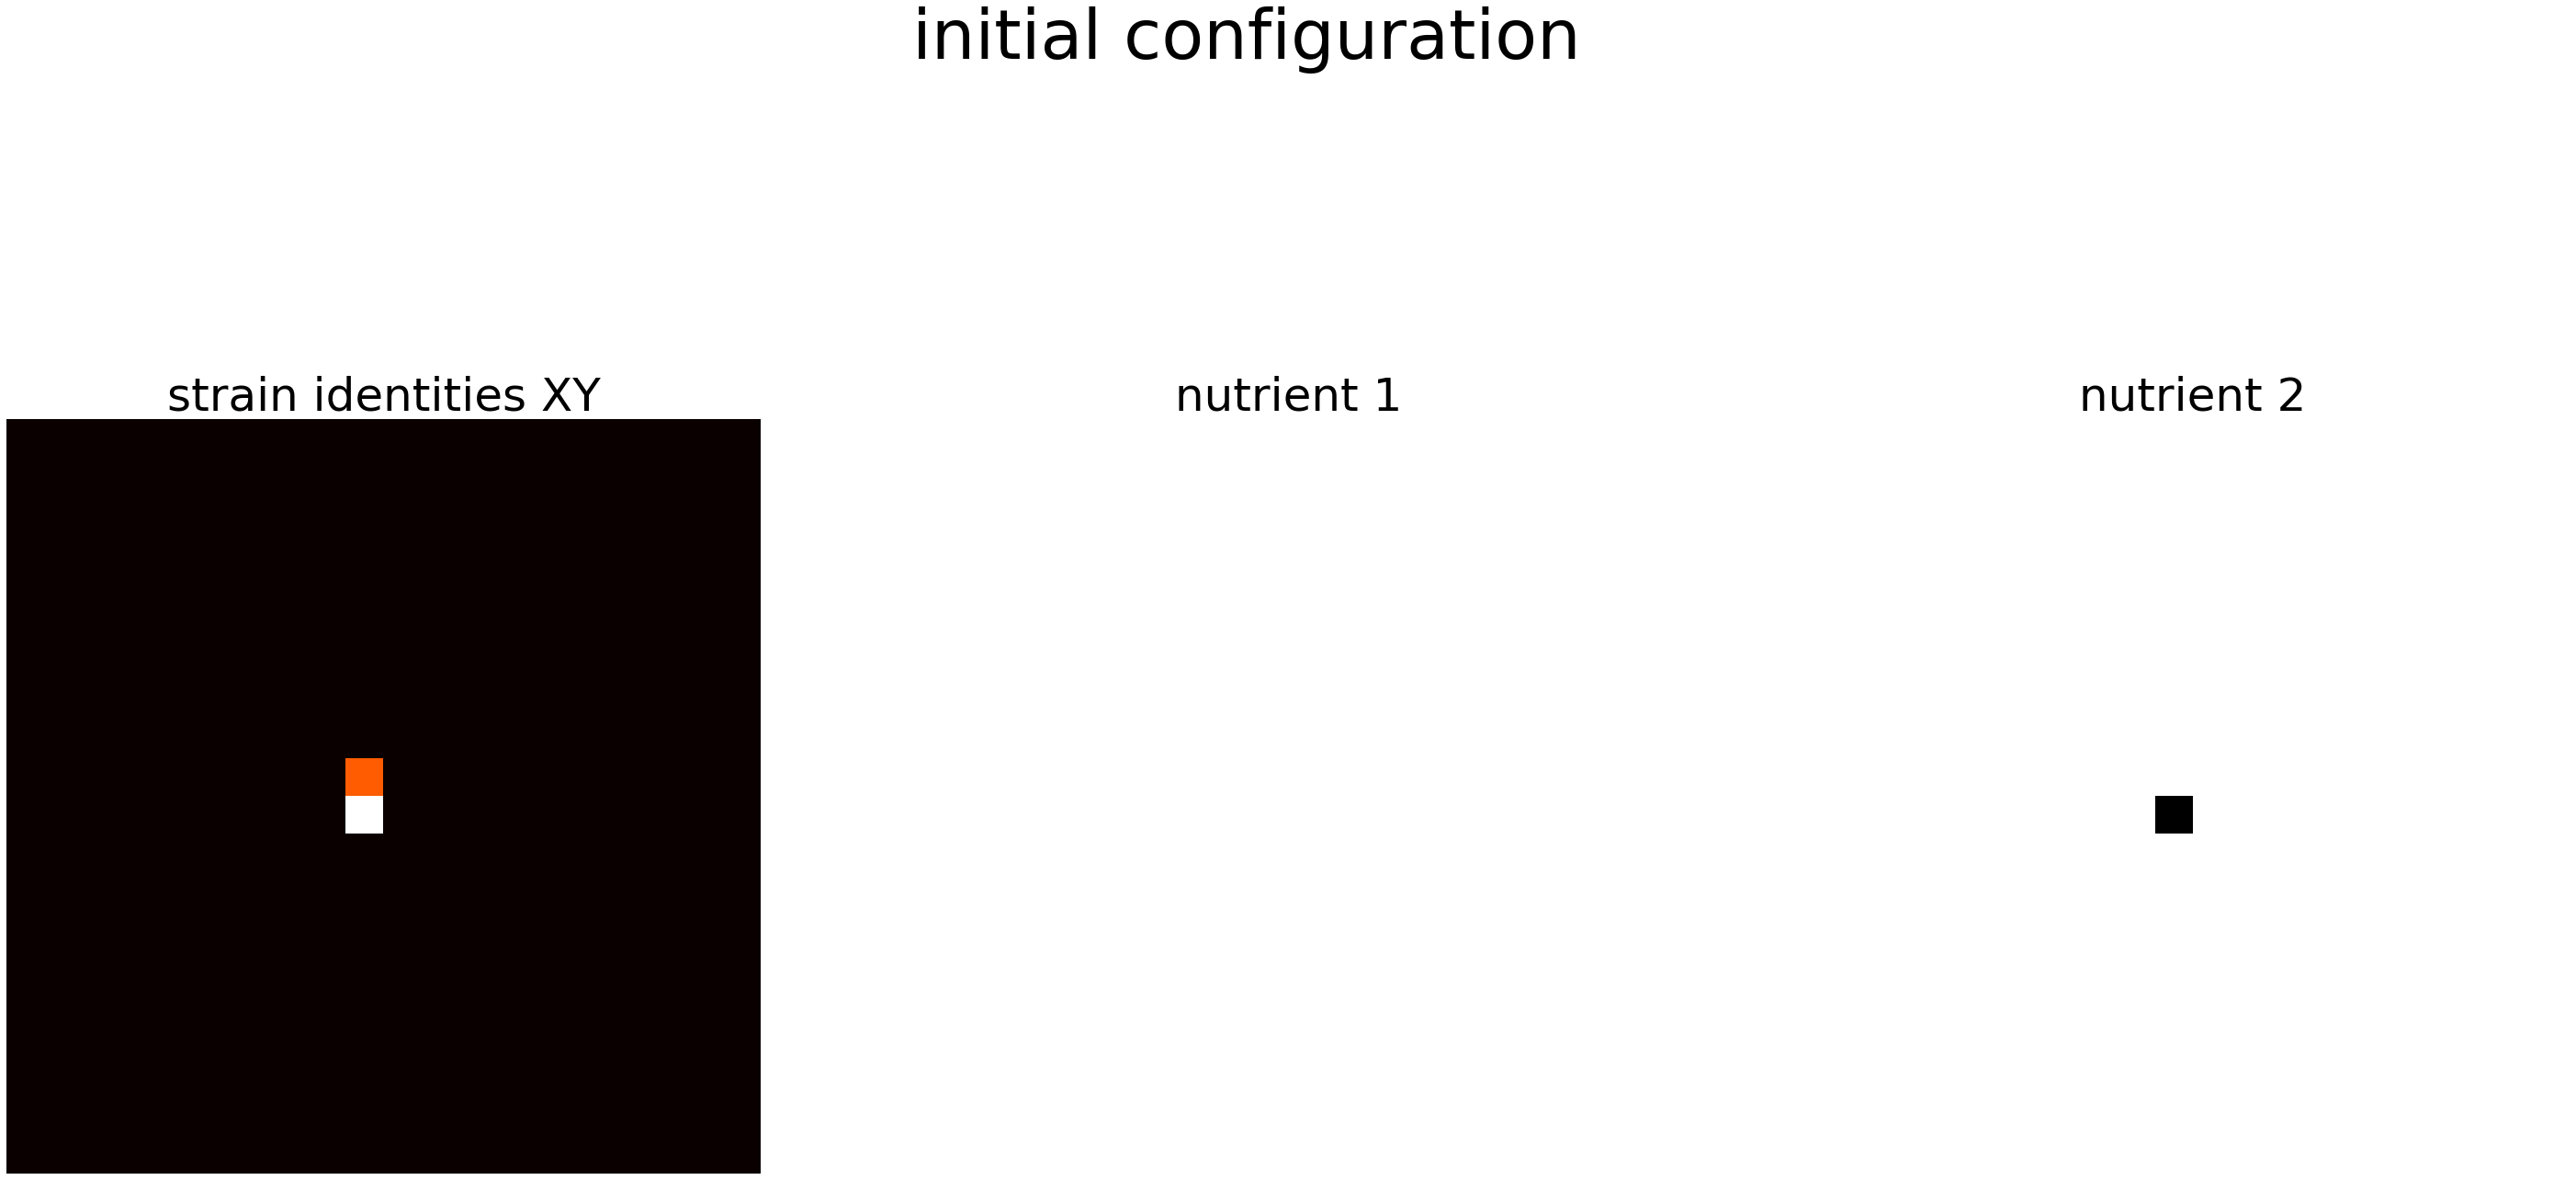

In [20]:
t_final = 50 #hours
dt = 0.1 #hours

nsteps = int(t_final/dt)
time = np.arange(nsteps)/dt

draw_config_conc(X,nutrients,n_nutrients,'initial configuration')
for tt in range(nsteps):
    
    X,nutrients = iterate_life_and_death(X,n_nutrients,nutrients,dependencies)
    #draw_config_conc(X,nutrients,n_nutrients,'configuration t = %s'%(dt + dt*tt))
    
print('Done! :D')

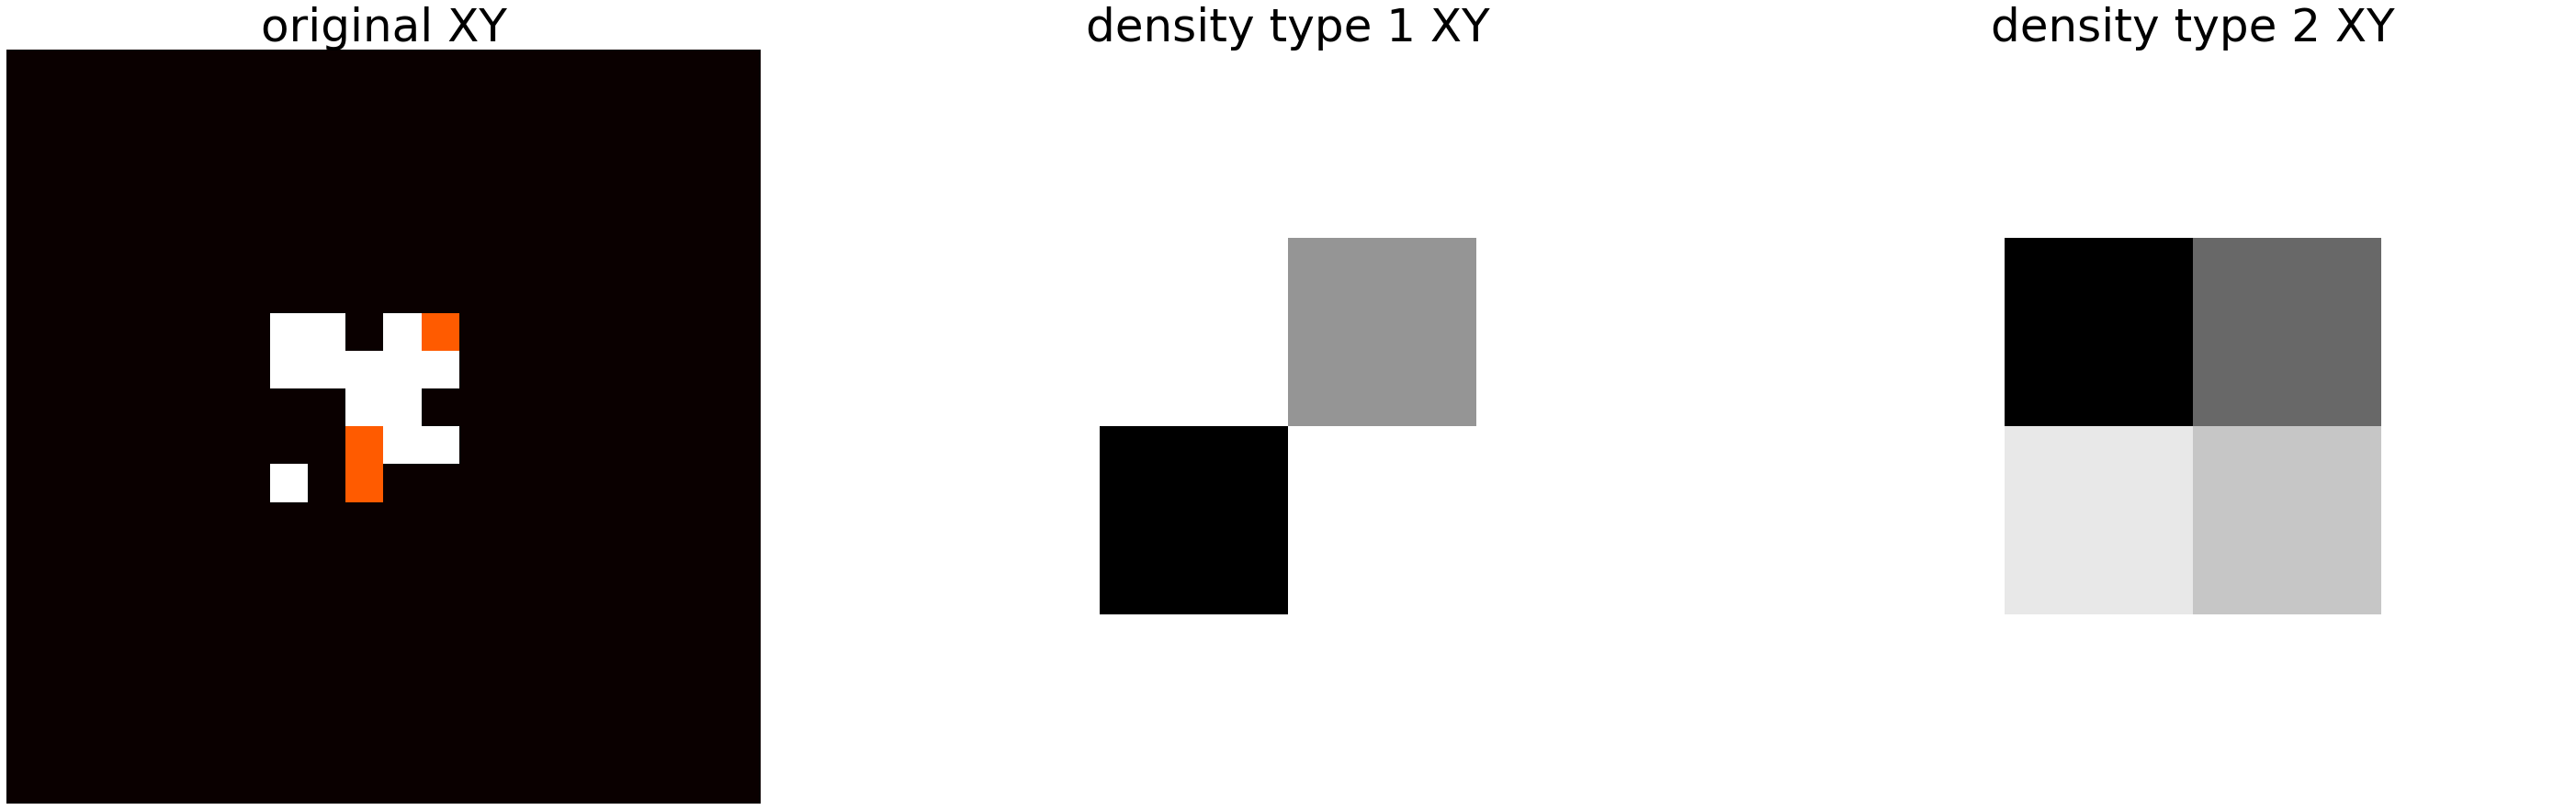

In [228]:
#initialize a big grid
#lets start this test by plotting
X = populate_X_S_internal(X,nutrients,side_len,cell_size,n_strains,density,n_nutrients,dependencies)
X_1, X_2 = draw(X)